<a href="https://colab.research.google.com/github/NMashalov/2021-DGM-MIPT-course/blob/main/NMT_Mashalov.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab assignment 02

### Neural Machine Translation in the wild
In the third homework you are supposed to get the best translation you can for the EN-RU translation task.

Basic approach using RNNs as encoder and decoder is implemented for you. 

Your ultimate task is to use the techniques we've covered, e.g.

* Optimization enhancements (e.g. learning rate decay)

* Transformer/CNN/<whatever you select> encoder (with or without positional encoding)

* attention/self-attention mechanism

* pretraining the language models (for decoder and encoder)

* or just fine-tunning BART/ELECTRA/... ;)

to improve the translation quality. 

__Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__

Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [ ]:
# You might need to install the libraries below. Do it in the desired environment
# if you are working locally.

! pip  install subword-nmt torchtext==0.6.0 nltk -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 44.5 MB/s eta 0:00:00


In [ ]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

import os
path_do_data = 'data.txt'
if not os.path.exists(path_do_data):
    print("Dataset not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt -nc
    path_do_data = './data.txt'

Dataset not found locally. Downloading from github.
--2023-05-21 19:06:42--  https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12905334 (12M) [text/plain]
Saving to: ‘data.txt’

data.txt            100%[===================>]  12.31M  --.-KB/s    in 0.07s   

2023-05-21 19:06:42 (184 MB/s) - ‘data.txt’ saved [12905334/12905334]



Baseline solution BLEU score is quite low. Try to achieve at least __21__ BLEU on the test set. 
The checkpoints are:

* __21__ - minimal score to submit the homework, 30% of points

* __25__ - good score, 70% of points

* __27__ - excellent score, 100% of points

### Warning! The code below is deeeeeeeply deprecated and is is provided only as simple guide.
We suggest you to stick to most recent pipelines here, e.g. by Huggingface: 
* Example notebook: [link](https://github.com/huggingface/notebooks/blob/main/examples/translation.ipynb)
* Converting your own dataset to specific format: [link](https://discuss.huggingface.co/t/correct-way-to-create-a-dataset-from-a-csv-file/15686/15)

In [ ]:
# old deprecated code
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator

import spacy

import random
import math
import time

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE


### Main part
__Here comes the preprocessing. Do not hesitate to use BPE or more complex preprocessing ;)__

In [ ]:
tokenizer_W = WordPunctTokenizer()
def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

SRC = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

dataset = torchtext.data.TabularDataset(
    path=path_do_data,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

NameError: ignored

Here are tokens from original (RU) corpus:

In [ ]:
SRC.vocab.itos[::1000]

['<unk>',
 'ле',
 'las',
 'канала',
 '59',
 'ana',
 'ming',
 'фортепианную',
 'доривала',
 'трамвай']

Let's check the length distributions:

Length distribution in Train data


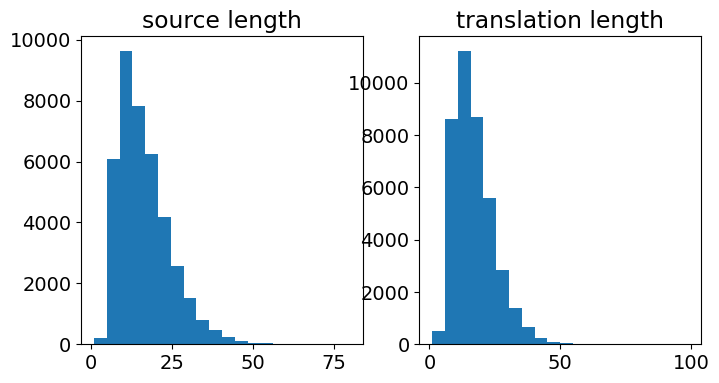

In [ ]:
src_length = map(len, [vars(x)['src'] for x in train_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in train_data.examples])

print('Length distribution in Train data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

Length distribution in Test data


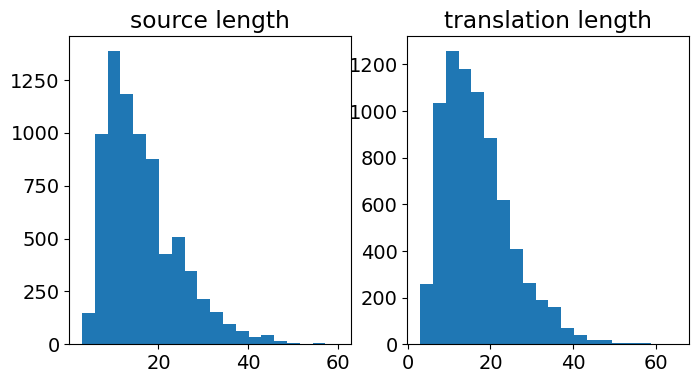

In [ ]:
src_length = map(len, [vars(x)['src'] for x in test_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in test_data.examples])

print('Length distribution in Test data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

### Model side
__Here comes simple pipeline of NMT model learning. It almost copies the week03 practice__

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cuda')

In [ ]:
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

for x in train_iterator:
    break
print(x)
print(x.src.shape, x.trg.shape)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator

import random
import math
import time


class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
#         self.dropout = dropout
        
        self.embedding = nn.Embedding(
            num_embeddings=input_dim,
            embedding_dim=emb_dim
        )
            # <YOUR CODE HERE>
        
        self.rnn = nn.LSTM(
            input_size=emb_dim,
            hidden_size=hid_dim,
            num_layers=n_layers,
            dropout=dropout
        )
            # <YOUR CODE HERE>
        
        self.dropout = nn.Dropout(p=dropout)# <YOUR CODE HERE>
        
    def forward(self, src):
        
        #src = [src sent len, batch size]
        
        # Compute an embedding from the src data and apply dropout to it
        embedded = self.embedding(src)# <YOUR CODE HERE>
        
        embedded = self.dropout(embedded)
        
        output, (hidden, cell) = self.rnn(embedded)
        #embedded = [src sent len, batch size, emb dim]
        
        # Compute the RNN output values of the encoder RNN. 
        # outputs, hidden and cell should be initialized here. Refer to nn.LSTM docs ;)
        
        # <YOUR CODE HERE> 
        
        #outputs = [src sent len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #outputs are always from the top hidden layer
        
        return hidden, cell
    

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.output_dim = output_dim
        self.n_layers = n_layers
        self.dropout = dropout
        
        self.embedding = nn.Embedding(
            num_embeddings=output_dim,
            embedding_dim=emb_dim
        )
            # <YOUR CODE HERE>
        
        self.rnn = nn.LSTM(
            input_size=emb_dim,
            hidden_size=hid_dim,
            num_layers=n_layers,
            dropout=dropout
        )
            # <YOUR CODE HERE>
        
        self.out = nn.Linear(
            in_features=hid_dim,
            out_features=output_dim
        )
            # <YOUR CODE HERE>
        
        self.dropout = nn.Dropout(p=dropout)# <YOUR CODE HERE>
        
    def forward(self, input, hidden, cell):
        
        #input = [batch size]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #n directions in the decoder will both always be 1, therefore:
        #hidden = [n layers, batch size, hid dim]
        #context = [n layers, batch size, hid dim]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        # Compute an embedding from the input data and apply dropout to it
        embedded = self.dropout(self.embedding(input))# <YOUR CODE HERE>
        
        #embedded = [1, batch size, emb dim]
        
        # Compute the RNN output values of the encoder RNN. 
        # outputs, hidden and cell should be initialized here. Refer to nn.LSTM docs ;)
        # <YOUR CODE HERE>
        
        
        #output = [sent len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #sent len and n directions will always be 1 in the decoder, therefore:
        #output = [1, batch size, hid dim]
        #hidden = [n layers, batch size, hid dim]
        #cell = [n layers, batch size, hid dim]
        
        
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        prediction = self.out(output.squeeze(0))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden, cell


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src sent len, batch size]
        #trg = [trg sent len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        # Again, now batch is the first dimention instead of zero
        batch_size = trg.shape[1]
        max_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(self.device)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, max_len):
            
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.max(1)[1]
            input = (trg[t] if teacher_force else top1)
        
        return outputs


In [ ]:
import my_network
Encoder = my_network.Encoder
Decoder = my_network.Decoder
Seq2Seq = my_network.Seq2Seq

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)

In [ ]:
def init_weights(m):
    # <YOUR CODE HERE>
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9252, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(6688, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=512, out_features=6688, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 14,868,000 trainable parameters


In [ ]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [ ]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

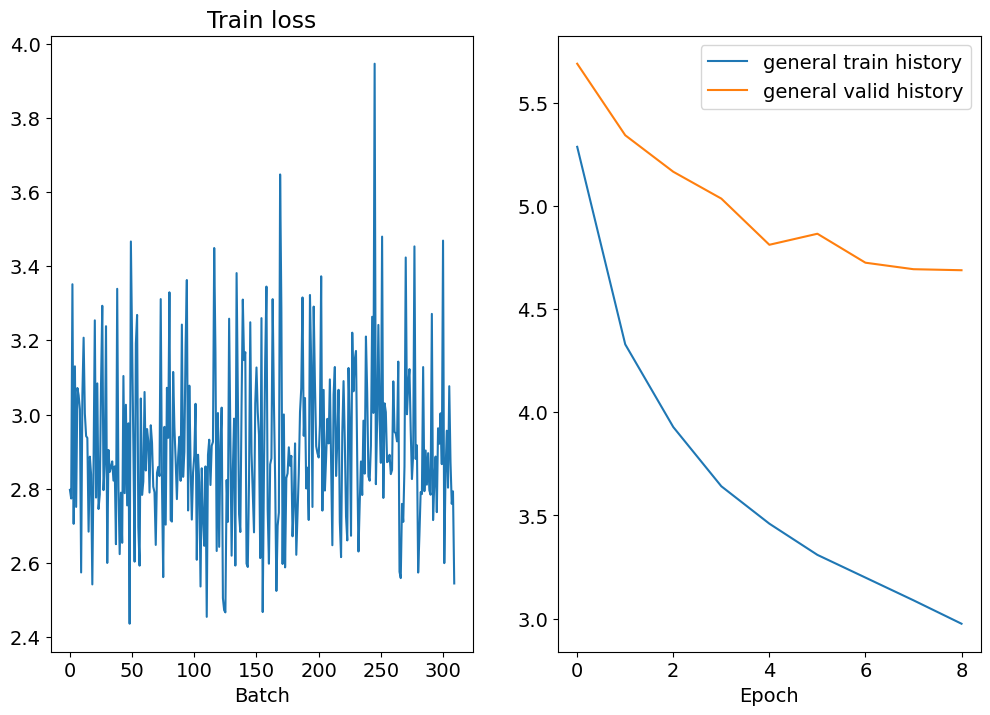

Epoch: 10 | Time: 2m 1s
	Train Loss: 2.911 | Train PPL:  18.376
	 Val. Loss: 4.659 |  Val. PPL: 105.539


In [ ]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

__Let's take a look at our network quality__:

NameError: ignored

In [ ]:
generate_translation = generate_translation
remove_tech_tokens = remove_tech_tokens
get_text = get_text
flatten = flatten

In [ ]:
batch = next(iter(test_iterator))

In [ ]:
for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: a dishwasher is also available .
Generated: the kitchen is equipped with a dishwasher and a .

Original: the reception desk is open 24 hours a day .
Generated: a 24 - hour front desk .



In [ ]:
from nltk.translate.bleu_score import corpus_bleu

def generate_translation(src, trg, model, TRG_vocab):
    model.eval()

    output = model(src, trg, 0) #turn off teacher forcing
    output = output.argmax(dim=-1).cpu().numpy()

    original = get_text(list(trg[:,0].cpu().numpy()), TRG_vocab)
    generated = get_text(list(output[1:, 0]), TRG_vocab)
    
    print('Original: {}'.format(' '.join(original)))
    print('Generated: {}'.format(' '.join(generated)))
    print()

def flatten(l):
    return [item for sublist in l for item in sublist]

def remove_tech_tokens(mystr, tokens_to_remove=['<eos>', '<sos>', '<unk>', '<pad>']):
    return [x for x in mystr if x not in tokens_to_remove]


def get_text(x, TRG_vocab):
    text = [TRG_vocab.itos[token] for token in x]
    try:
        end_idx = text.index('<eos>')
        text = text[:end_idx]
    except ValueError:
        pass
    text = remove_tech_tokens(text)
    if len(text) < 1:
        text = []
    return text



original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)


#     """ Estimates corpora-level BLEU score of model's translations given inp and reference out """
#     translations, _ = model.translate_lines(inp_lines, **flags)
#     # Note: if you experience out-of-memory error, split input lines into batches and translate separately
#     return corpus_bleu([[ref] for ref in out_lines], translations) * 100

In [ ]:
import tqdm

59it [00:06,  8.43it/s]


In [ ]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

14.354085903946906

GRU Attention

In [ ]:
# You might need to install the libraries below. Do it in the desired environment
# if you are working locally.

!pip  install subword-nmt torchtext==0.6.0 nltk -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.5 MB/s eta 0:00:00


In [ ]:
from nltk.tokenize import WordPunctTokenizer
import torchtext
from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator
import torch

import os
path_do_data = 'data.txt'
if not os.path.exists(path_do_data):
    print("Dataset not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt -nc
    path_do_data = './data.txt'
    
tokenizer_W = WordPunctTokenizer()
def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

SRC = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True,
            include_lengths = True
            )

TRG = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

dataset = torchtext.data.TabularDataset(
    path=path_do_data,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Dataset not found locally. Downloading from github.
--2023-05-23 16:28:40--  https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12905334 (12M) [text/plain]
Saving to: ‘data.txt’

data.txt            100%[===================>]  12.31M  --.-KB/s    in 0.1s    

2023-05-23 16:28:41 (90.0 MB/s) - ‘data.txt’ saved [12905334/12905334]

Unique tokens in source (ru) vocabulary: 9270
Unique tokens in target (en) vocabulary: 6686


In [ ]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.nn as nn
import torch.nn.functional as F


class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, enc_units,dropout):
        super(Encoder, self).__init__()
        self.enc_units = enc_units
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.gru = nn.GRU(self.embedding_dim, self.enc_units,num_layers=2)
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, x, lens):
        
        # x: max_length, batch_size, embedding_dim
        x = self.dropout(self.embedding(x)) 
                
        # x transformed = max_len X batch_size X embedding_dim
        # x = x.permute(1,0,2)
        x = pack_padded_sequence(x, lens) # unpad
        
        # output: max_length, batch_size, enc_units
        # self.hidden: 1, batch_size, enc_units
        output, hidden = self.gru(x) # gru returns hidden state of all timesteps as well as hidden state at last timestep
        
        # pad the sequence to the max length in the batch
        output, _ = pad_packed_sequence(output)
        
        return output, hidden

class Decoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, dec_units, enc_units,dropout):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.enc_units = enc_units
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.gru = nn.GRU(self.embedding_dim + self.enc_units, 
                          self.dec_units,
                          batch_first=True,
                          num_layers=2)
        
        self.bn1 = nn.BatchNorm1d(self.enc_units)
        self.fc1 = nn.Linear(self.enc_units, self.vocab_size//2)
        self.fc2 = nn.Linear(self.vocab_size//2, self.vocab_size)

        # used for attention
        self.W1 = nn.Linear(self.enc_units, self.dec_units)
        self.W2 = nn.Linear(self.enc_units, self.dec_units)
        self.V = nn.Linear(self.enc_units, 1)
        self.dropout = nn.Dropout(p=dropout)
    
    def forward(self, x, hidden, enc_output):
        # enc_output original: (max_length, batch_size, enc_units)
        # enc_output converted == (batch_size, max_length, hidden_size)
        enc_output = enc_output.permute(1,0,2)
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        hidden_with_time_axis = hidden[1].unsqueeze(0).permute(1, 0, 2)
        
        # score: (batch_size, max_length, hidden_size) # Bahdanaus's
        # we get 1 at the last axis because we are applying tanh(FC(EO) + FC(H)) to self.V
        # It doesn't matter which FC we pick for each of the inputs
        score = torch.tanh(self.W1(enc_output) + self.W2(hidden_with_time_axis))
        
        #score = torch.tanh(self.W2(hidden_with_time_axis) + self.W1(enc_output))
          
        # attention_weights shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        attention_weights = torch.softmax(self.V(score), dim=1)
        
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * enc_output
        context_vector = torch.sum(context_vector, dim=1)
        
        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        # takes case of the right portion of the model above (illustrated in red)
        x = self.dropout(self.embedding(x))
    
        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        #x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        # ? Looks like attention vector in diagram of source
        x = torch.cat((context_vector.unsqueeze(1), x), -1)
        
        # passing the concatenated vector to the GRU
        # output: (batch_size, 1, hidden_size)
        output, state = self.gru(x,hidden)
        
        # output shape == (batch_size * 1, hidden_size)
        output =  self.bn1(output.view(-1, output.size(2)))
        
        # output shape == (batch_size * 1, vocab)
        x = F.relu(self.fc1(output))
        x = self.fc2(x)

        return x, state, attention_weights
    



In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 256
BATCH_SIZE = 100
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
teacher_forcing_ratio = 0.5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## TODO: Combine the encoder and decoder into one class
encoder = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM,ENC_DROPOUT)
decoder = Decoder(INPUT_DIM, DEC_EMB_DIM, HID_DIM, HID_DIM,DEC_DROPOUT)

encoder.to(device)
decoder.to(device)

parametrs = list(encoder.parameters()) + list(decoder.parameters())

optimizer = torch.optim.Adam(parametrs, 
                       lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

PAD_IDX = TRG.vocab.stoi['<pad>']
START_IDX = TRG.vocab.stoi['<sos>']
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

def loss_function(real, pred):
    """ Only consider non-zero inputs in the loss; mask needed """
    #mask = 1 - np.equal(real, 0) # assign 0 to all above 0 and 1 to all 0s
    #print(mask)
    mask = real.ge(1).type(torch.cuda.FloatTensor)
    
    loss_ = criterion(pred, real) * mask 
    return torch.mean(loss_)


train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort=False, 
)

def sort_batch(X, y, lengths):
    lengths, indx = lengths.sort(dim=0, descending=True)
    X = X[:,indx]
    y = y[:,indx]
    return X, y, lengths 

In [ ]:
torch.cuda.empty_cache()

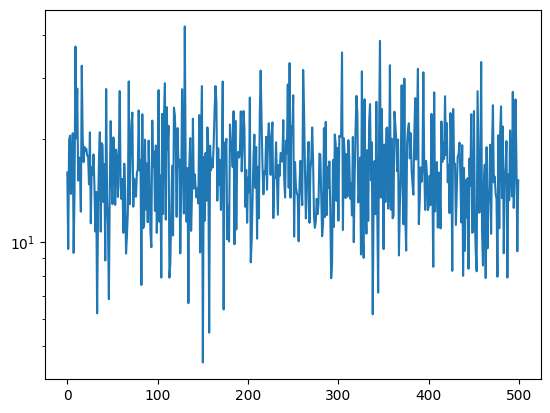

KeyboardInterrupt: ignored

In [ ]:
import time 
from IPython.display import clear_output
import matplotlib.pyplot as plt
import random
EPOCHS = 20

history=[]

encoder.train()
decoder.train()

for epoch in range(EPOCHS):
    start = time.time()
    total_loss = 0
    
    for batch, data in enumerate(train_iterator):
        loss = 0
        inp, inp_len = data.src
        targ = data.trg
        xs, ys, lens = sort_batch(inp, targ, inp_len)
        enc_output, dec_hidden = encoder(xs, lens.cpu())

        # use teacher forcing - feeding the target as the next input (via dec_input)
        dec_input = torch.tensor([[START_IDX]] * int(ys.size(1)),device=device)
        
        # run code below for every timestep in the ys batch
        for t in range(1, ys.size(0)):
            predictions, dec_hidden, _ = decoder(dec_input, 
                                         dec_hidden, 
                                         enc_output)
            loss += torch.mean(criterion(predictions,ys[t]))
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = predictions.max(1)[1].unsqueeze(1)
            dec_input = ys[t].unsqueeze(1) if teacher_force else top1
            
        loss.backward()
        torch.nn.utils.clip_grad_norm_(parametrs, 1)
        optimizer.step()
        optimizer.zero_grad()
        batch_loss = (loss / int(ys.size(1)))
        total_loss += batch_loss
    
        history.append(batch_loss.detach().item())
            
        if (batch+1) % 10 == 0:
            clear_output(True)
            plt.plot(history[::10])
            plt.yscale('log')
            plt.show()
    scheduler.step()
        
    ### TODO: Save checkpoint for model

    torch.save(encoder.state_dict(), f'encoder-model-{epoch + 1}.pt')
    torch.save(decoder.state_dict(), f'decoder-model-{epoch + 1}.pt')
    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                        total_loss / len(train_iterator)))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    

In [ ]:
torch.save(encoder.state_dict(), f'encoder-model-final.pt')
torch.save(decoder.state_dict(), f'decoder-model-final.pt')

In [ ]:
encoder.load_state_dict(torch.load('encoder-model-final.pt'))
decoder.load_state_dict(torch.load('decoder-model-final.pt'))

encoder.eval()
decoder.eval()

total_loss = 0

with torch.no_grad():
    for batch, data in enumerate(valid_iterator):
        loss=0
        inp, inp_len = data.src
        targ = data.trg
        xs, ys, lens = sort_batch(inp, targ, inp_len)
        enc_output, enc_hidden = encoder(xs, lens.cpu())
        dec_hidden = enc_hidden
        
        # use teacher forcing - feeding the target as the next input (via dec_input)
        dec_input = torch.tensor([[START_IDX]] * int(ys.size(1)),device=device)
        
        # run code below for every timestep in the ys batch
        for t in range(1, ys.size(0)):
            predictions, dec_hidden, _ = decoder(dec_input, 
                                            dec_hidden, 
                                            enc_output)
            loss += criterion(predictions,ys[t])
            dec_input = predictions.max(1)[1].unsqueeze(1)
        batch_loss = (loss / int(ys.size(1)))
        total_loss += batch_loss

print(total_loss/ len(valid_iterator))

tensor(2.9743, device='cuda:0')


In [ ]:
train_iterator,test_iterator = BucketIterator.splits(
    (train_data, test_data), 
    batch_size = 5, 
    device = device,
    sort_key=lambda x: x.src[1],
    shuffle=True
)

encoder.eval()
decoder.eval()

test_examples = next(iter(train_iterator))

inp, inp_len = test_examples.src
targ = test_examples.trg
xs, ys, lens = sort_batch(inp, targ, inp_len)
enc_output, dec_hidden = encoder(xs, lens.cpu())
# use teacher forcing - feeding the target as the next input (via dec_input)
dec_input = torch.tensor([[START_IDX]] * int(ys.size(1)),device=device)
translation = []
translation.append(dec_input)


for t in range(1, ys.size(0)):
    predictions, dec_hidden, _ = decoder(dec_input, 
                                    dec_hidden, 
                                    enc_output)
    dec_input = predictions.max(1)[1].unsqueeze(1)
    translation.append(dec_input)

inps = xs.T.detach().cpu().numpy()
results = torch.concatenate(translation,axis=1).detach().cpu().numpy()
reals = ys.T.detach().cpu().numpy()

In [ ]:
tokens_to_remove = ['<eos>', '<sos>', '<unk>', '<pad>']

for inp, real, result in zip(inps,reals,results):
    print('Исходный текст:',' '.join([SRC.vocab.itos[token] for token in inp]))
    print('Мой перевод:',' '.join([TRG.vocab.itos[token] for token in result if token not in tokens_to_remove]))
    print('Правильный перевод:',' '.join([TRG.vocab.itos[token] for token in real]))

Исходный текст: <sos> в отеле и конференц - центре howard johnson plaza гости могут посещать крытый бассейн , сезонный открытый бассейн и фитнес - центр , а также пользоваться прачечной самообслуживания . <eos>
Мой перевод: <sos> a fitness centre , fitness centre , fitness centre , fitness centre , fitness centre , fitness centre and fitness centre , fitness centre and fitness centre . <eos> fitness centre . <eos> fitness centre . <eos>
Правильный перевод: <sos> an indoor pool and an outdoor seasonal pool are featured at kansas city howard johnson plaza hotel and conference center . guests can exercise in the fitness centre or make use of the launderette facilities . <eos>
Исходный текст: <sos> к услугам гостей номера с бесплатным доступом в интернет и кабельным телевидением , а также кафе , бар и бесплатная парковка . <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Мой перевод: <sos> the hotel offers free parking , it features free private parking on site . <eos> on - site restaurant 

In [ ]:
def remove_tech_tokens(mystr, tokens_to_remove=['<eos>', '<sos>', '<unk>', '<pad>']):
    return [x for x in mystr if x not in tokens_to_remove]


def get_text(x, TRG_vocab):
    text = [TRG_vocab.itos[token] for token in x]
    try:
        end_idx = text.index('<eos>')
        text = text[:end_idx]
    except ValueError:
        pass
    text = remove_tech_tokens(text)
    if len(text) < 1:
        text = []
    return text

original_text = []
generated_text = []
encoder.eval()
decoder.eval()
with torch.no_grad():
    for i, test_examples in enumerate(test_iterator):
        inp, inp_len = test_examples.src
        targ = test_examples.trg
        xs, ys, lens = sort_batch(inp, targ, inp_len)
        enc_output, dec_hidden = encoder(xs, lens.cpu())
        # use teacher forcing - feeding the target as the next input (via dec_input)
        dec_input = torch.tensor([[START_IDX]] * int(ys.size(1)),device=device)
        translation = []
        translation.append(dec_input)
        for t in range(1, ys.size(0)):
            predictions, dec_hidden, _ = decoder(dec_input, 
                                            dec_hidden, 
                                            enc_output)
            dec_input = predictions.max(1)[1].unsqueeze(1)
            translation.append(dec_input)
        results = torch.concatenate(translation,axis=1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in targ.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in results.detach().cpu().numpy().T])

In [ ]:
len(original_text), len(original_text)

(7500, 7500)

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
corpus_bleu(original_text, generated_text) * 100

NameError: ignored

In [ ]:
generated_text[:10]

[[],
 ['offering', 'a', 'with', 'a', 'the'],
 ['a', 'a', 'a', 'breakfast', 'guests'],
 ['10', 'breakfast', 'the'],
 ['is', '-', 'breakfast', 'shops'],
 ['a', 'minute', 'is', 'and'],
 ['quiet', 'drive', 'available', 'restaurants'],
 ['-', 'from', 'daily', 'and'],
 ['winning', 'the', '.', 'restaurants'],
 ['hotel', 'centre', 'is']]

Transformer

In [ ]:
from nltk.tokenize import WordPunctTokenizer

import os
path_do_data = 'data.txt'
if not os.path.exists(path_do_data):
    print("Dataset not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt -nc
    path_do_data = './data.txt'

MAX_LENGTH = 128

tokenizer_W = WordPunctTokenizer()
def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

SRC = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True,
            )

TRG = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

dataset = torchtext.data.TabularDataset(
    path=path_do_data,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

def _len_sort_key(x):
    return len(x.src)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BATCH_SIZE = 1

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

for x in train_iterator:
    break
print(x.src.squeeze())
print(x.src.shape, x.trg.shape)

In [ ]:
from torch import Tensor
import torch
import torch.nn as nn
from torch.nn import Transformer
import math
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# helper Module that adds positional encoding to the token embedding to introduce a notion of word order.
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

# helper Module to convert tensor of input indices into corresponding tensor of token embeddings
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

# Seq2Seq Network
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

In [ ]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [ ]:
torch.manual_seed(0)

SRC_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE])
TGT_VOCAB_SIZE = len(vocab_transform[TGT_LANGUAGE])
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 128
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

In [ ]:
from torch.nn.utils.rnn import pad_sequence

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([BOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

# ``src`` and ``tgt`` language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tensors
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch

In [ ]:
from timeit import default_timer as timer
NUM_EPOCHS = 18

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer)
    end_time = timer()
    val_loss = evaluate(transformer)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))


# function to generate output sequence using greedy algorithm
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
    return ys


# actual function to translate input sentence into target language
def translate(model: torch.nn.Module, src_sentence: str):
    model.eval()
    src = text_transform[SRC_LANGUAGE](src_sentence).view(-1, 1)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
    return " ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<bos>", "").replace("<eos>", "")

# BERT finetuning

In [ ]:
corpus_bleu([[text] for text in original_text], generated_text) * 100
from nltk.translate.bleu_score import corpus_bleu


original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

In [ ]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

import os
path_do_data = 'data.txt'
if not os.path.exists(path_do_data):
    print("Dataset not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt -nc
    path_do_data = './data.txt'

Dataset not found locally. Downloading from github.
--2023-05-20 21:13:30--  https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12905334 (12M) [text/plain]
Saving to: ‘data.txt’

data.txt            100%[===================>]  12.31M  --.-KB/s    in 0.04s   

2023-05-20 21:13:30 (321 MB/s) - ‘data.txt’ saved [12905334/12905334]



In [ ]:
!pip install transformers accelerate datasets sentencepiece -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.1/219.1 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 44.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 61.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from datasets import load_dataset
dataset = load_dataset("csv",  data_files="data.txt",delimiter='\t',column_names=['source', 'target',], split='train').train_test_split(test_size=0.2)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-7bc61aea1a0f1d5e/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['source', 'target'],
        num_rows: 40000
    })
    test: Dataset({
        features: ['source', 'target'],
        num_rows: 10000
    })
})

In [ ]:
from transformers import MBartForConditionalGeneration, MBart50TokenizerFast

tokenizer = MBart50TokenizerFast.from_pretrained("facebook/mbart-large-50", src_lang="en_XX", tgt_lang="ru_RU")
model = MBartForConditionalGeneration.from_pretrained("facebook/mbart-large-50")

In [ ]:
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer

In [ ]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

In [ ]:
max_input_length = 128
max_target_length = 128

def preprocess_function(examples):
    model_inputs = tokenizer(examples['source'], max_length=max_input_length, truncation=True)

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples['target'], max_length=max_target_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [ ]:
args = Seq2SeqTrainingArguments(output_dir="./results",
                        do_train=True,
                        evaluation_strategy = "epoch",
                        per_device_train_batch_size=1,
                        max_steps = 500,
                        learning_rate=2e-5,
                        predict_with_generate=True,
                        fp16=True,
                        save_total_limit=3,
                        logging_dir="/logs")

In [ ]:
tokenized_datasets = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3606: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
import torch

trainer = Seq2SeqTrainer(model=model, 
    args=args, 
    data_collator=data_collator, 
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a MBart50TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss
0,3.233400,1.881686


TrainOutput(global_step=500, training_loss=3.23338916015625, metrics={'train_runtime': 338.4822, 'train_samples_per_second': 1.477, 'train_steps_per_second': 1.477, 'total_flos': 22837399732224.0, 'train_loss': 3.23338916015625, 'epoch': 0.01})

In [ ]:
from transformers import pipeline

# Replace this with your own checkpoint
model_checkpoint = "huggingface-course/marian-finetuned-kde4-en-to-fr"
translator = pipeline("translation", model=model_checkpoint)

#Transformer

In [ ]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

import os
path_do_data = 'data.txt'
if not os.path.exists(path_do_data):
    print("Dataset not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt -nc
    path_do_data = './data.txt'

Dataset not found locally. Downloading from github.
--2023-05-22 04:53:58--  https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12905334 (12M) [text/plain]
Saving to: ‘data.txt’

data.txt            100%[===================>]  12.31M  --.-KB/s    in 0.1s    

2023-05-22 04:54:00 (98.8 MB/s) - ‘data.txt’ saved [12905334/12905334]



In [ ]:
!pip install datasets -q

In [ ]:
from datasets import load_dataset
dataset = load_dataset("csv",  data_files="data.txt",delimiter='\t',column_names=['source', 'target',], split='train').train_test_split(test_size=0.2)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-ddd63ac03072a3fa/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['source', 'target'],
        num_rows: 40000
    })
    test: Dataset({
        features: ['source', 'target'],
        num_rows: 10000
    })
})

In [ ]:
import torchtext.transforms as T

max_seq_len = 50

T.Truncate(max_seq_len - 2),

(Truncate(),)